In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 10
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
data_freq = "M"

In [3]:
electromen = pd.read_csv("./raw_data/electromenager.csv", sep=";", skiprows=2)
electromen.columns = ["date", "indice", "autre"]
electromen = electromen[["date", "indice"]]
electromen = electromen.sort_values(by=["date"])
electromen.index = pd.to_datetime(electromen["date"])
electromen.head()

,date,indice
date,,
2005-01-01,2005-01,48.25
2005-02-01,2005-02,44.86
2005-03-01,2005-03,49.79
2005-04-01,2005-04,52.08
2005-05-01,2005-05,53.33


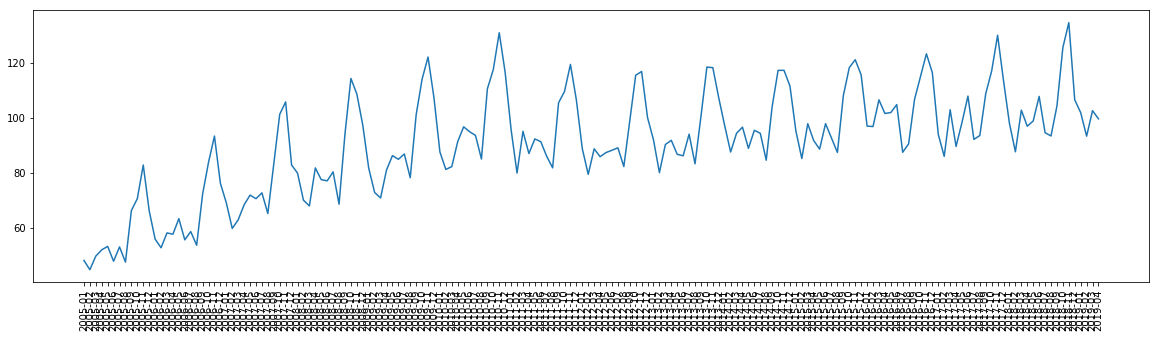

In [4]:
fig = plt.figure(1, figsize=(20, 5))
plt.xticks(rotation="vertical")
plt.plot(electromen["date"], electromen["indice"])

In [19]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(freq=data_freq, 
                            prediction_length=12, 
                            trainer=Trainer(epochs=10))

from gluonts.dataset.common import ListDataset

training_data = ListDataset(
    [{"start": electromen.index[0], "target": electromen.indice[:datetime(2017, 12, 31)]}],
    freq = data_freq
)

INFO:root:Using CPU


In [20]:
predictor = estimator.train(training_data=training_data)

INFO:root:Start model training
INFO:root:Number of parameters in DeepARTrainingNetwork: 13463
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 28.17it/s, avg_epoch_loss=4.78]
INFO:root:Epoch[0] Elapsed time 1.777 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=4.776773
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 31.48it/s, avg_epoch_loss=3.73]
INFO:root:Epoch[1] Elapsed time 1.591 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=3.731967
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 32.70it/s, avg_epoch_loss=3.44]
INFO:root:Epoch[2] Elapsed time 1.529 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=3.442156
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:01<00:00, 30.30it/s, avg_epoch_loss=3.32]
INFO:root:Epoch[3] Elapsed time 1.650 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=3.318752
INFO:root:Epoch[4] Learning rate is 0.001


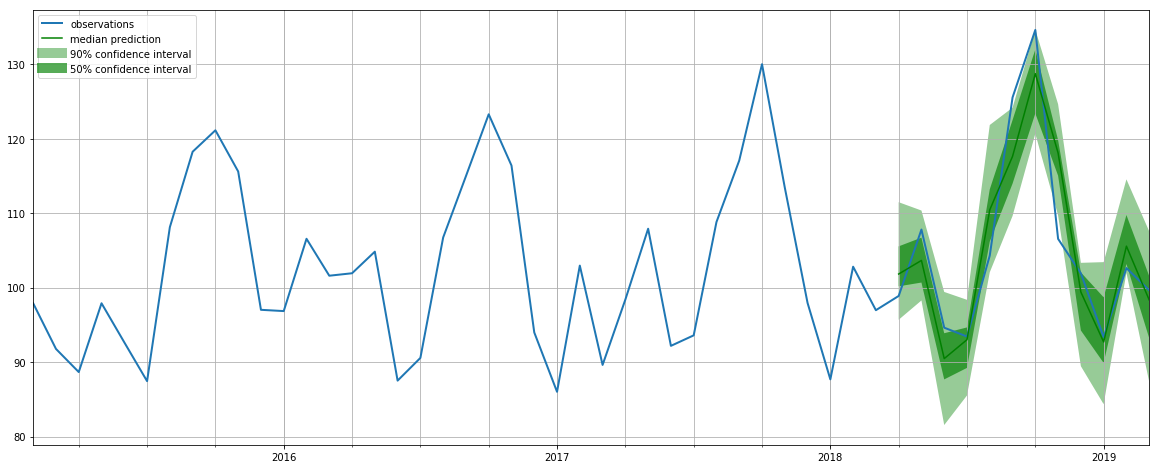

In [31]:
test_data = ListDataset(
    [
        {"start": electromen.index[0], "target": electromen.indice[:datetime(2019, 4, 1)]}
    ],
    freq = data_freq
)

from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(20, 8), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor, num_eval_samples=24)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=50, num_plots=1)

In [17]:
help(make_evaluation_predictions)

Help on function make_evaluation_predictions in module gluonts.evaluation.backtest:

make_evaluation_predictions(dataset: gluonts.dataset.common.Dataset, predictor: gluonts.model.predictor.Predictor, num_eval_samples: int) -> Tuple[Iterator[gluonts.model.forecast.Forecast], Iterator[pandas.core.series.Series]]
    Return predictions on the last portion of predict_length time units of the
    target. Such portion is cut before making predictions, such a function can
    be used in evaluations where accuracy is evaluated on the last portion of
    the target.
    
    Parameters
    ----------
    dataset
        Dataset where the evaluation will happen. Only the portion excluding
        the prediction_length portion is used when making prediction.
    predictor
        Model used to draw predictions.
    num_eval_samples
        Number of samples to draw on the model when evaluating.
    
    Returns
    -------



In [32]:
dir(forecast)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_dim',
 '_index',
 '_mean',
 '_sorted_samples',
 '_sorted_samples_value',
 'as_json_dict',
 'copy_dim',
 'dim',
 'freq',
 'index',
 'info',
 'item_id',
 'mean',
 'mean_ts',
 'num_samples',
 'plot',
 'prediction_length',
 'quantile',
 'samples',
 'start_date']

In [33]:
forecast.quantile

<bound method SampleForecast.quantile of SampleForecast(array([[101.31665 ],
       [115.35421 ],
       [122.621056]], dtype=float32)), Timestamp('2019-03-31 00:00:00', freq='M'), 'M', item_id=None, info=None)>

In [34]:
forecast

SampleForecast(array([[101.31665 ],
       [115.35421 ],
       [122.621056]], dtype=float32)), Timestamp('2019-03-31 00:00:00', freq='M'), 'M', item_id=None, info=None)